In [1]:
import torch
import torch.utils.data as torchdata
import numpy as np
import datetime as dt

import time

import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from flax import linen as nn
from flax import traverse_util
from flax.core.frozen_dict import freeze

import os
import sys
sys.path.append("/project")

import model.hydro.gr4j_prod as t_prod
import model.hydro.gr4j_prod_flax as j_prod
from model.ml.lstm_flax import LSTM
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate, nse
from data.utils import read_dataset_from_file, get_station_list
from data.camels_sampler import CamelsBatchSampler


In [2]:

from tqdm import tqdm

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax 

In [3]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '105105A' #'917107A'
run_dir = '/project/results/hygr4j'

x1_init = 0.530927 # 0.8 #np.random.normal(0.6, 0.12) 
s_init = 0.0 #np.random.uniform(0.0, 0.3)

window_size = 7
batch_size = 256
n_epoch = 250


hidden_dim = 16
lstm_dim = 32
dropout = 0.2
n_features = 5
output_dim = 1

lr = 5e-4

weight_decay = 0.1

In [4]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 105105A


In [5]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)

In [6]:
X_train = torch.nan_to_num(X_train)
X_val = torch.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [7]:
t_prod_store = t_prod.ProductionStorage(s_init=s_init, x1=x1_init)
t_x_out = t_prod_store(X_train, include_x=True)[0]

x_mu = t_x_out.mean(dim=0).numpy()
x_sigma = t_x_out.std(dim=0).numpy()

In [8]:
class HyGR4J(nn.Module):
    x1_init: float
    s_init: float
    x_mu: np.ndarray
    x_sigma: np.ndarray
    hidden_dim: int
    lstm_dim: int
    output_dim: int=1
    dropout_p: float=0.2
    window_size: int=7
    training: bool=True
    scale: float=1000.0

    def setup(self):
        self._prod_store = j_prod.ProductionStorage(x1_init=self.x1_init,
                                                   s_init=self.s_init,
                                                   scale=self.scale)
        self._model = LSTM(hidden_dim=self.hidden_dim,
                            lstm_dim=self.lstm_dim,
                            output_dim=self.output_dim,
                            dropout_p=self.dropout_p,
                            training=self.training)
    
    def create_sequence(self, X, q):

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - self.window_size):
            Xs.append(jnp.concatenate([
                                    X[i: (i + self.window_size)],
                                    q[i - 1:(i + self.window_size) - 1]
                                ], axis=1))

        Xs = jnp.stack(Xs)
        return Xs

    
    def __call__(self, x, q):
        prod_out, s_store = self._prod_store(x)
        prod_out = (prod_out - self.x_mu)/self.x_sigma
        # prod_out = jnp.concatenate([prod_out, s_store.reshape(-1, 1)], axis=1)
        seq = self.create_sequence(prod_out, q)
        q_out = self._model(seq)
        return q_out, s_store[-window_size-2]
         


In [9]:
# Key Generators
# root_key = jax.random.PRNGKey(seed=1)
# main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

In [10]:
hygr4j = HyGR4J(x1_init=x1_init, s_init=s_init, 
                lstm_dim=lstm_dim, hidden_dim=hidden_dim,
                output_dim=output_dim, dropout_p=dropout,
                x_mu=x_mu, x_sigma=x_sigma, window_size=window_size)


In [11]:
train_ds = torchdata.TensorDataset(X_train, y_train)
train_batch_sampler = CamelsBatchSampler(train_ds, batch_size=batch_size, 
                                         window_size=window_size,
                                         drop_last=False)
train_dl = torchdata.DataLoader(train_ds, batch_sampler=train_batch_sampler, 
                                num_workers=2, prefetch_factor=2)




val_ds = torchdata.TensorDataset(X_val, y_val)
val_batch_sampler = CamelsBatchSampler(val_ds, batch_size=batch_size, 
                                       window_size=window_size,
                                       drop_last=False)
val_dl = torchdata.DataLoader(val_ds, batch_sampler=val_batch_sampler,
                              num_workers=2, prefetch_factor=2)


In [12]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

In [13]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.random.KeyArray

def create_train_state(module, rngs, lr):
    """Creates an initial `TrainState`."""
    
    params = module.init(rngs, 
                         jnp.ones([batch_size, n_features]), 
                         jnp.ones([batch_size, 1]))['params']
    
    # tx = optax.adamw(lr, b1=0.80, b2=0.90, weight_decay=weight_decay)

    
    partition_optimizers = {
        'ml': optax.adamw(lr, b1=0.88, b2=0.96,
                          weight_decay=weight_decay),
        'gr4j': optax.set_to_zero() #optax.adam(1e-3, b1=0.88, b2=0.96)
    }
    param_partitions = freeze(traverse_util.path_aware_map(
        lambda path, v: 'gr4j' if '_prod_store' in path else 'ml', params)
    )
    tx = optax.multi_transform(partition_optimizers, param_partitions)

    return TrainState.create(apply_fn=module.apply, 
                             params=params, tx=tx,
                             key=rngs['dropout'],
                             metrics=Metrics.empty())

In [14]:
@jax.jit
def train_step(state, batch, targets):
    """Train for a single step."""
    
    def loss_fn(params):
        preds, s_store = state.apply_fn({'params': params}, batch, targets,
                                rngs={'dropout': jax.random.PRNGKey(1)})
        loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
        return loss
    
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state

In [15]:
@jax.jit
def compute_metrics(*, state, batch, targets):
    
    preds, s_store = state.apply_fn({'params': state.params}, batch, targets,
                            rngs={'dropout': jax.random.PRNGKey(1)})
    
    loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
    
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state, s_store

In [16]:
state = create_train_state(hygr4j, rngs=init_rngs, lr=lr)

In [17]:
metrics_history = {'train_loss': [],
                   'test_loss': [],
                   'x1': []}

In [18]:
# Early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [19]:
pbar = tqdm(range(1, n_epoch+1))

for epoch in pbar:

    hygr4j.s_init = s_init
    hygr4j.training = True

    # Train step
    for step, (batch, targets) in enumerate(train_dl):

        batch = batch.detach().numpy()
        targets = targets.detach().numpy()

        state = train_step(state, batch, targets)
        state, s_store_train = compute_metrics(state=state, 
                                               batch=batch, targets=targets)
        hygr4j.s_init = s_store_train/(state.params['_prod_store']['x1']*hygr4j.scale)
    
    for metric, value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty())

    # Validation step
    test_state = state
    hygr4j.s_init = s_init
    hygr4j.training = False
    for step, (batch, targets) in enumerate(val_dl):
        batch = batch.detach().numpy()
        targets = targets.detach().numpy()
        test_state, s_store_test = compute_metrics(state=test_state, 
                                                   batch=batch, targets=targets)
        hygr4j.s_init = s_store_test/(test_state.params['_prod_store']['x1']*hygr4j.scale)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    metrics_history['x1'].append(state.params['_prod_store']['x1'])
    
    pbar.set_description(f"""Epoch {epoch}/{n_epoch} loss: {metrics_history['train_loss'][-1]:.4f} val_loss: {metrics_history['test_loss'][-1]:.4f}""")

    if early_stopper.early_stop(metrics_history['test_loss'][-1]):
        break

Epoch 51/250 loss: 0.2328 val_loss: 0.2429:  20%|██        | 50/250 [02:10<08:43,  2.62s/it]


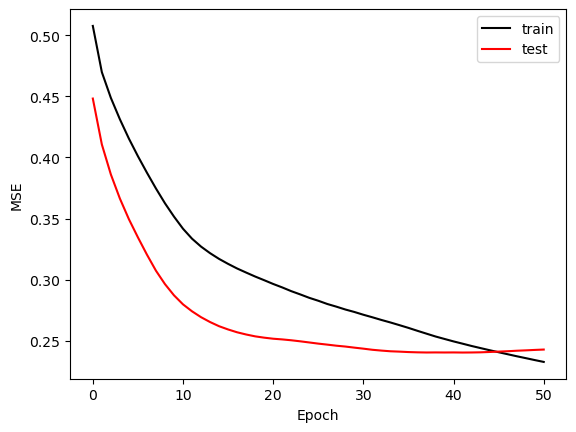

In [20]:
train_loss = jnp.array(metrics_history['train_loss'])
test_loss = jnp.array(metrics_history['test_loss'])

plt.plot(train_loss, color='black', label='train')
plt.plot(test_loss, color='red', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

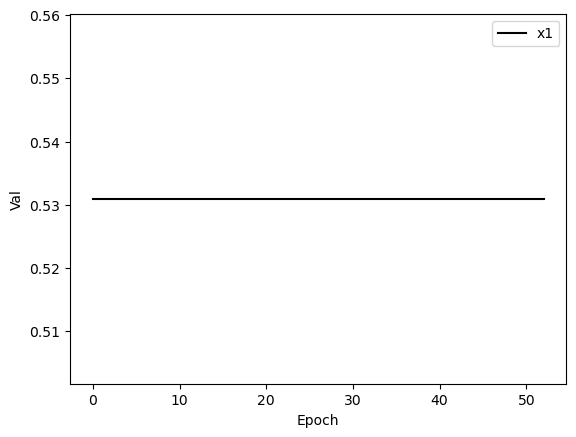

In [123]:
x1 = jnp.array(metrics_history['x1'])

plt.plot(x1, color='black', label='x1')
plt.xlabel('Epoch')
plt.ylabel('Val')
plt.legend()

In [21]:
def evaluate(module, state=None, params=None, dl=None):

    if params is None:
        if state is None:
            raise("No params provided!")
        params = state.params

    y_mu_np = y_mu.detach().numpy()
    y_sigma_np = y_sigma.detach().numpy()
    module.training = False

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    hygr4j.training = False
    hygr4j.s_init = s_init

    for i, (X, y) in enumerate(dl, start=1):

        X = X.detach().numpy()
        y = y.detach().numpy()
        
        y_hat, s_store = module.apply({'params': params}, X, y)
        hygr4j.s_init = s_store/(params['_prod_store']['x1']*hygr4j.scale)

        P.append(X[window_size+1:, 0])
        ET.append(X[window_size+1:, 1])

        Q.append((y[window_size+1:]*y_sigma_np+y_mu_np))
        Q_hat.append((y_hat*y_sigma_np+y_mu_np))

    Q = np.concatenate(Q, axis=0)
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q_hat = jnp.clip(np.concatenate(Q_hat, axis=0), 0)

    nse_score = nse(Q, Q_hat)

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot(P, 'g--', label='precip', alpha=0.40)
    ax.plot(ET, 'y--', label='etp', alpha=0.30)
    ax.plot(Q, color='black', label='obs', alpha=1.0)
    ax.plot(Q_hat, color='red', label='pred', alpha=0.75)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Flow (mm/day)')

    ax.annotate(f'NSE: {nse_score:.4f}',
            xy=(0.8, 0.88), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)
    ax.set_title('Streamflow prediction')

    plt.legend()


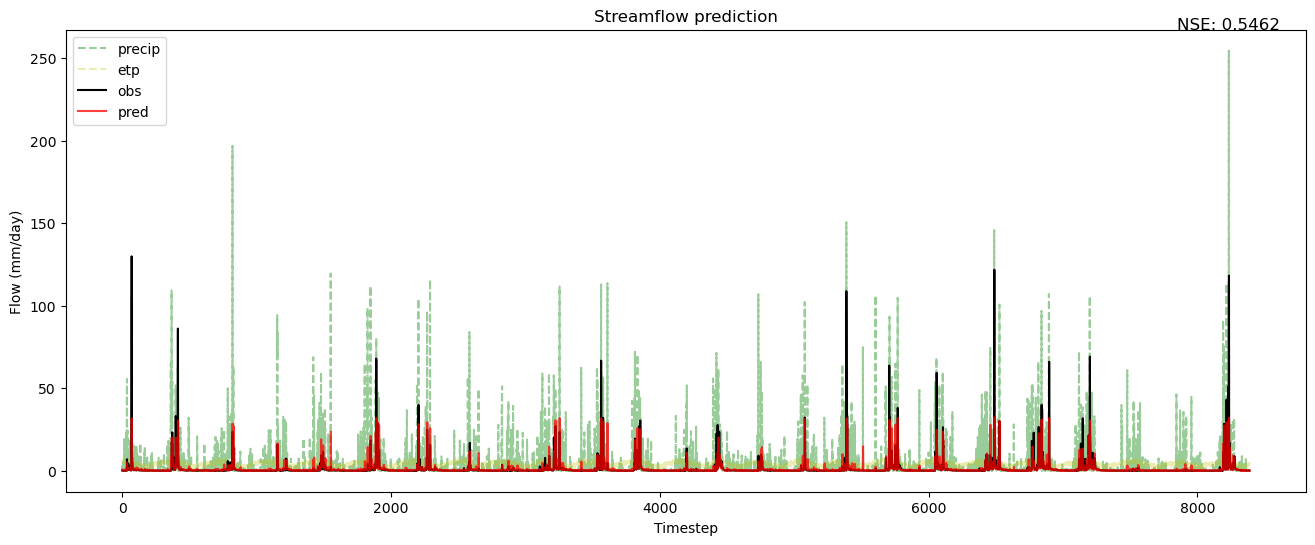

In [22]:
evaluate(module=hygr4j, state=state, dl=train_dl)

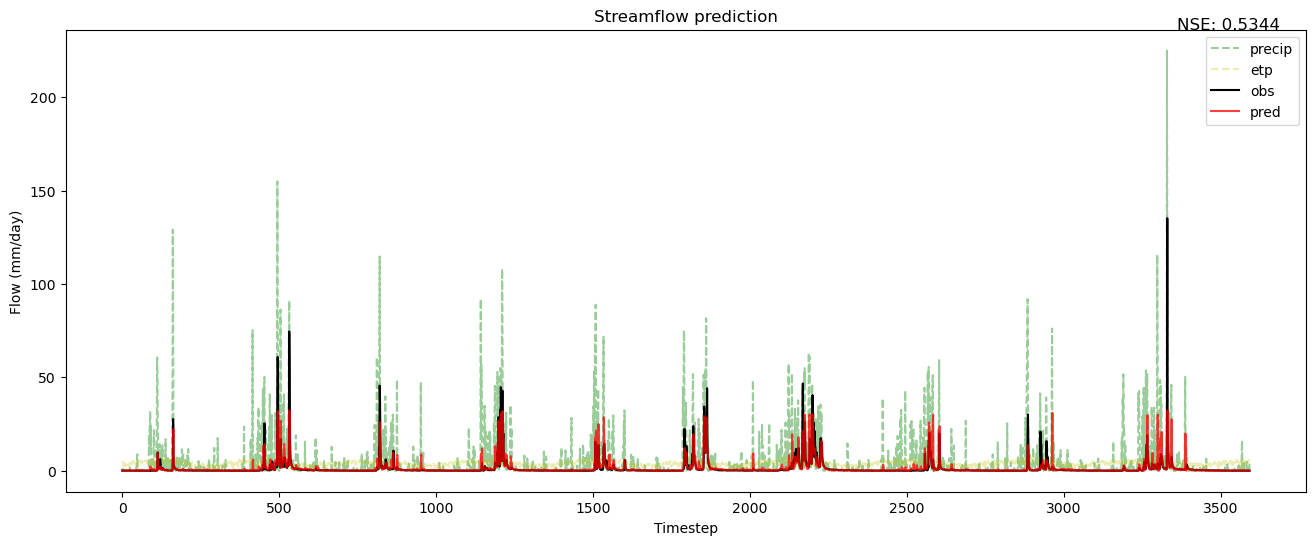

In [23]:
evaluate(module=hygr4j, state=state, dl=val_dl)

In [24]:
def create_unfrozen_train_state(module, state, lr):

    tx = optax.adamw(lr, b1=0.80, b2=0.90, weight_decay=weight_decay)

    return TrainState.create(apply_fn=module.apply, 
                             params=state.params, tx=tx,
                             key=init_rngs['dropout'],
                             metrics=Metrics.empty())

In [25]:
unfrozen_state = create_unfrozen_train_state(module=hygr4j, state=state, lr=1e-3)

In [26]:
pbar = tqdm(range(1, 101))
# Early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in pbar:

    hygr4j.s_init = s_init
    hygr4j.training = True

    # Train step
    for step, (batch, targets) in enumerate(train_dl):

        batch = batch.detach().numpy()
        targets = targets.detach().numpy()

        unfrozen_state = train_step(unfrozen_state, batch, targets)
        unfrozen_state, s_store_train = compute_metrics(state=unfrozen_state,
                                               batch=batch, targets=targets)
        hygr4j.s_init = s_store_train/(state.params['_prod_store']['x1']*hygr4j.scale)
    
    for metric, value in unfrozen_state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    unfrozen_state = unfrozen_state.replace(metrics=unfrozen_state.metrics.empty())

    # Validation step
    test_state = unfrozen_state
    hygr4j.s_init = s_init
    hygr4j.training = False
    for step, (batch, targets) in enumerate(val_dl):
        batch = batch.detach().numpy()
        targets = targets.detach().numpy()
        test_state, s_store_test = compute_metrics(state=test_state, 
                                                   batch=batch, targets=targets)
        hygr4j.s_init = s_store_test/(test_state.params['_prod_store']['x1']*hygr4j.scale)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    pbar.set_description(f"""Epoch {epoch}/{100} loss: {metrics_history['train_loss'][-1]:.4f} val_loss: {metrics_history['test_loss'][-1]:.4f}""")

    if early_stopper.early_stop(metrics_history['test_loss'][-1]):
        break

Epoch 10/100 loss: 0.2080 val_loss: 0.2469:   9%|▉         | 9/100 [00:57<09:40,  6.38s/it] 


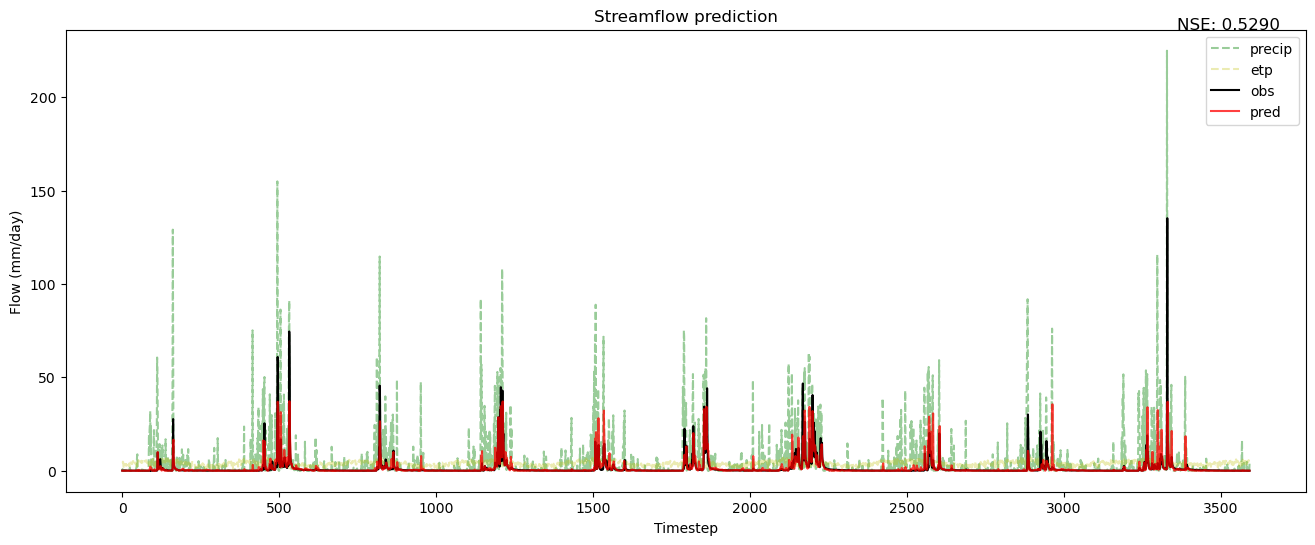

In [27]:
evaluate(module=hygr4j, state=unfrozen_state, dl=val_dl)

In [28]:
# unfrozen_params = frozen_state.params.unfreeze()
# unfrozen_params['_prod_store']['x1'] = jnp.array([0.93])

In [132]:
# evaluate(module=hygr4j, params=unfrozen_params, dl=val_dl)